In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

In [4]:
def evaluate_llm_performance(df, dataset_name=""):
    df = df[df['human_annotator1'] == df['human_annotator2']].copy()

    df['gold_label'] = df['human_annotator1']

    llm_cols = {
        "LLaMA-3-8B": "comments_categ_llama",
        "Gemma-2-9B": "comments_categ_gemma",
        "Qwen-2-7B": "comments_categ_qwen"
    }

    results = {}

    print(f"\n=== Evaluating LLMs on {dataset_name} ===")

    for llm_name, col in llm_cols.items():
        y_pred = df[col]
        y_true = df['gold_label']

        accuracy = accuracy_score(y_true, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

        results[llm_name] = {
            "Accuracy": round(accuracy, 3),
            "Precision": round(precision, 3),
            "Recall": round(recall, 3),
            "F1 Score": round(f1, 3)
        }

        print(f"\n==== {llm_name} Classification Report ====")
        print(classification_report(y_true, y_pred, zero_division=0))

    summary_df = pd.DataFrame(results).T
    print("\n===== Summary Metrics Across LLMs =====")
    print(summary_df)

    colors = ['#9999FF', '#99FF99', '#FF9999', '#FFCC99']

    plt.figure(figsize=(10, 6))
    ax = summary_df[['Accuracy', 'Precision', 'Recall', 'F1 Score']].plot(
        kind='bar', figsize=(10, 6), edgecolor='black', color=colors
    )

    plt.title(f"{dataset_name}", fontweight='bold', fontsize=18)
    plt.xlabel("LLM Models", fontweight='bold', fontsize=14)
    plt.ylabel("Score", fontweight='bold', fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold')

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(p.get_x() + p.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9, fontweight='bold')

    plt.ylim(0, 1.05)
    plt.xticks(rotation=0)
    plt.legend(loc="lower right")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, frameon=True, fontsize=10, prop={'weight':'bold'})

    filename = f"llm_performance_{dataset_name.lower().replace(' ', '_').replace('/', '_')}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"\nPlot saved as {filename}")

    plt.show()

    return summary_df



=== Evaluating LLMs on r/SuicideWatch ===

==== LLaMA-3-8B Classification Report ====
              precision    recall  f1-score   support

           1       0.58      0.48      0.52        23
           2       0.37      0.68      0.48        19
           3       0.50      0.45      0.47        20
           4       0.90      0.45      0.60        20

    accuracy                           0.51        82
   macro avg       0.59      0.52      0.52        82
weighted avg       0.59      0.51      0.52        82


==== Gemma-2-9B Classification Report ====
              precision    recall  f1-score   support

           1       0.42      0.70      0.52        23
           2       0.82      0.47      0.60        19
           3       0.50      0.20      0.29        20
           4       0.60      0.75      0.67        20

    accuracy                           0.54        82
   macro avg       0.58      0.53      0.52        82
weighted avg       0.58      0.54      0.52        82


<Figure size 1000x600 with 0 Axes>

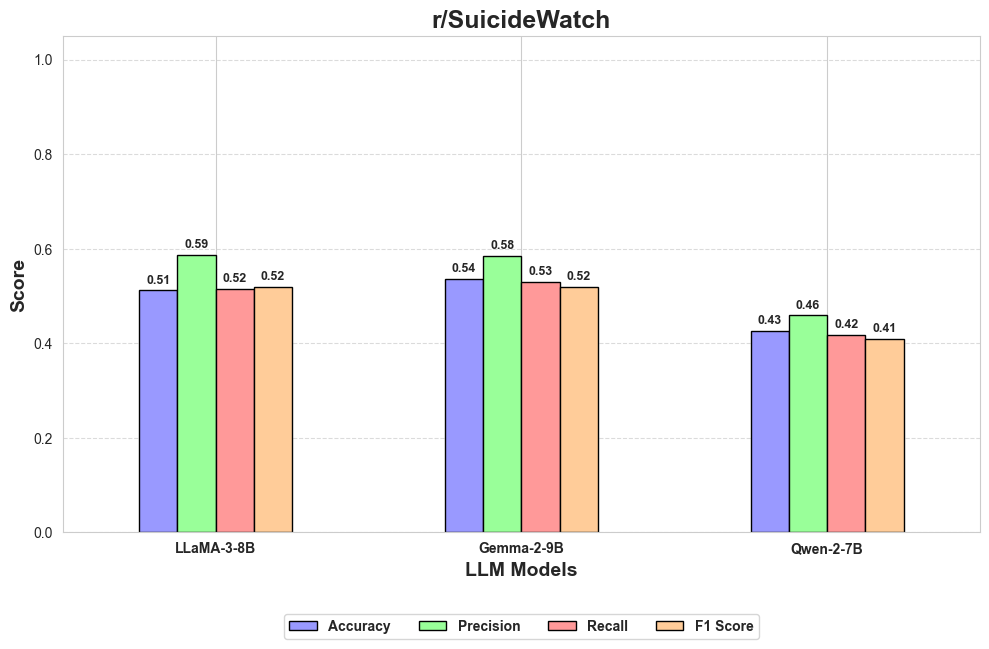


=== Evaluating LLMs on r/depression ===

==== LLaMA-3-8B Classification Report ====
              precision    recall  f1-score   support

           1       0.61      0.44      0.51        25
           2       0.31      0.73      0.43        15
           3       0.75      0.60      0.67        25
           4       0.80      0.42      0.55        19

    accuracy                           0.54        84
   macro avg       0.62      0.55      0.54        84
weighted avg       0.64      0.54      0.55        84


==== Gemma-2-9B Classification Report ====
              precision    recall  f1-score   support

           1       0.40      0.68      0.51        25
           2       1.00      0.47      0.64        15
           3       0.50      0.20      0.29        25
           4       0.56      0.74      0.64        19

    accuracy                           0.51        84
   macro avg       0.62      0.52      0.52        84
weighted avg       0.57      0.51      0.49        84




<Figure size 1000x600 with 0 Axes>

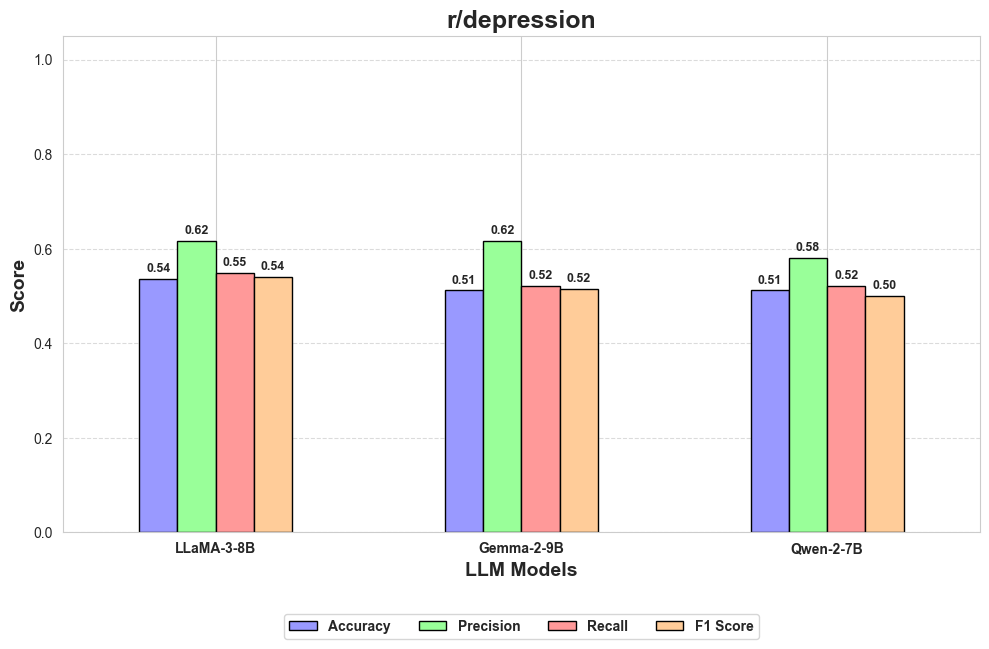

In [5]:
# suicide dataset
suicide_df = pd.read_csv("suicide_comment_sample.csv")
suicide_summary = evaluate_llm_performance(suicide_df, dataset_name="r/SuicideWatch")

# depression dataset
depression_df = pd.read_csv("depression_comment_sample.csv")
depression_summary = evaluate_llm_performance(depression_df, dataset_name="r/depression")


In [1]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd

def evaluate_llm_majority(df):
    df = df[df['human_annotator1'] == df['human_annotator2']].copy()
    df['gold_label'] = df['human_annotator1']

    def majority_vote(row):
        votes = [row['comments_categ_llama'], row['comments_categ_gemma'], row['comments_categ_qwen']]
        vote_counts = {v: votes.count(v) for v in set(votes)}
        max_vote = max(vote_counts.values())
        # Drop ties
        if list(vote_counts.values()).count(max_vote) > 1:
            return None
        return max(vote_counts, key=vote_counts.get)

    df['llm_majority'] = df.apply(majority_vote, axis=1)

    df = df[df['llm_majority'].notnull()]

    y_true = df['gold_label']
    y_pred = df['llm_majority']

    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

    return {
        "accuracy": round(accuracy, 4),
        "precision_macro": round(precision, 4),
        "recall_macro": round(recall, 4),
        "f1_macro": round(f1, 4),
        "n_evaluated": len(df)
    }

In [5]:
# suicide dataset
suicide_df = pd.read_csv("suicide_comment_sample.csv")
evaluate_llm_majority(suicide_df)

{'accuracy': 0.5672,
 'precision_macro': 0.6106,
 'recall_macro': 0.5782,
 'f1_macro': 0.5715,
 'n_evaluated': 67}

In [6]:
# depression dataset
depression_df = pd.read_csv("depression_comment_sample.csv")
evaluate_llm_majority(depression_df)

{'accuracy': 0.5811,
 'precision_macro': 0.6311,
 'recall_macro': 0.5768,
 'f1_macro': 0.5699,
 'n_evaluated': 74}